In [1]:
from validphys import convolution
from validphys.convolution import NFK, FK_FLAVOURS
from validphys.api import API
from validphys.fkparser import load_fktable

from super_net.constants import XGRID
from super_net.api import API as sAPI
from super_net.covmats import sqrt_covmat_jax
import jax.scipy.linalg as jla

import jax.numpy as jnp
import jax
import numpy as np
import pandas as pd

from super_net.loss_functions import make_chi2

import ultranest

In [2]:
inp = {
    "dataset_inputs": [{'dataset':'NMC'},   ],
    
    "theoryid": 400,
    "use_cuts": "internal",
    
    # wmin basis specs
    "wminpdfset": "210623_mnc_disonly_linear_1000",
    "n_replicas_wmin": 15,
    
    # Level 0 closure test
    "fakedata": True,
    "pseudodata": False, 
    "closure_test_pdf": "210623_mnc_disonly_linear_1000",
    
    # fit specs
    "use_t0": True,
    "t0pdfset": "210623_mnc_disonly_linear_1000",
    
    "bayesian_fit": True,
    "wmin_grid_index": 1, # random seed used for random parametrisation of wmin pdf
#     "replica_index": 1,  # random seed used for random noise to central values
    "trval_index": 1
}

In [3]:
data_values = sAPI.make_data_values(**inp)
pred_data = sAPI.make_pred_data(**inp)

LHAPDF 6.5.0 loading /Users/markcostantini/miniconda3/envs/new_jax_env/share/LHAPDF/210623_mnc_disonly_linear_1000/210623_mnc_disonly_linear_1000_0000.dat
210623_mnc_disonly_linear_1000 PDF set, member #0, version 1


In [4]:
def make_chi2(make_data_values, make_pred_data):
    """
    TODO
    """
    training_data = make_data_values.training_data
    central_values = training_data.central_values
    covmat = training_data.covmat
    central_values_idx = training_data.central_values_idx

    @jax.jit
    def chi2(pdf):
        """
        TODO
        """
        diff = (
            make_pred_data(pdf)[central_values_idx]
            - central_values
        )

        sqrt_covmat = jnp.array(sqrt_covmat_jax(covmat))

        # solve_triangular: solve the equation a x = b for x, assuming a is a triangular matrix.
        chi2_vec = jla.solve_triangular(sqrt_covmat, diff, lower=True)
        loss = jnp.sum(chi2_vec**2)
        return loss

    return chi2

chi2 = make_chi2(data_values, pred_data)

In [5]:
{i: FK_FLAVOURS[i] for i in range(len(FK_FLAVOURS))}

{0: 'photon',
 1: '\\Sigma',
 2: 'g',
 3: 'V',
 4: 'V3',
 5: 'V8',
 6: 'V15',
 7: 'V24',
 8: 'V35',
 9: 'T3',
 10: 'T8',
 11: 'T15',
 12: 'T24',
 13: 'T35'}

In [6]:
REDUCED_XGRID = [1e-5, 0.1, 0.2,] # 0.3, 0.9]

FLAVOUR_MAPPING = [1, 2, 3]




# @jax.jit
def interpolate_grid(stacked_pdf_grid):
    """
    TODO
    """
    
    # reshape stacked_pdf_grid to (len(REDUCED_XGRID), len(FLAVOUR_MAPPING))
    reshaped_stacked_pdf_grid = stacked_pdf_grid.reshape((len(REDUCED_XGRID), len(FLAVOUR_MAPPING)), order="F")
    
    # generate an empty matrix of shape (len(super_net.constants.XGRID),valipdhys.convolution.NFK)
    input_grid = jnp.zeros((len(XGRID), NFK))
    
    # interpolate columns of reshaped_stacked_pdf_grid
    for i, fl in enumerate(FLAVOUR_MAPPING):
        input_grid = input_grid.at[:,fl].set(jnp.interp(jnp.array(XGRID), jnp.array(REDUCED_XGRID), reshaped_stacked_pdf_grid[:,i]))
    
    return jnp.array(input_grid)


# @jax.jit
def log_likelihood(stacked_pdf_grid): 
        """
        TODO
        """
        pdf = interpolate_grid(stacked_pdf_grid).T

        return -0.5 * chi2(pdf)
    

In [7]:
[f"{FK_FLAVOURS[i]}({j})" for i in FLAVOUR_MAPPING for j in REDUCED_XGRID]


['\\Sigma(1e-05)',
 '\\Sigma(0.1)',
 '\\Sigma(0.2)',
 'g(1e-05)',
 'g(0.1)',
 'g(0.2)',
 'V(1e-05)',
 'V(0.1)',
 'V(0.2)']

In [8]:
parameters = [f"{FK_FLAVOURS[i]}({j})" for i in FLAVOUR_MAPPING for j in REDUCED_XGRID]

def prior_transform(cube):
    """
    TODO
    """
    params = cube.copy()
    for i in range(len(parameters)):
        params[i] = cube[i] 
    return params


sampler = ultranest.ReactiveNestedSampler(
    parameters,
    log_likelihood,
    prior_transform,
)

ultranest_result = sampler.run(
    min_num_live_points=400,
    min_ess=40,
)

2023-11-19 12:46:26.914101: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2023-11-19 12:46:27.005231: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+02  .10 [-536.9469..-536.9465]*| it/evals=8612/52265 eff=16.4716% N=331  
[ultranest] Likelihood function evaluations: 52265
[ultranest]   logZ = -554.3 +- 0.1215
[ultranest] Effective samples strategy satisfied (ESS = 2841.5, need >40)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.12 tail:0.02 total:0.12 required:<0.50
[ultranest] done iterating.


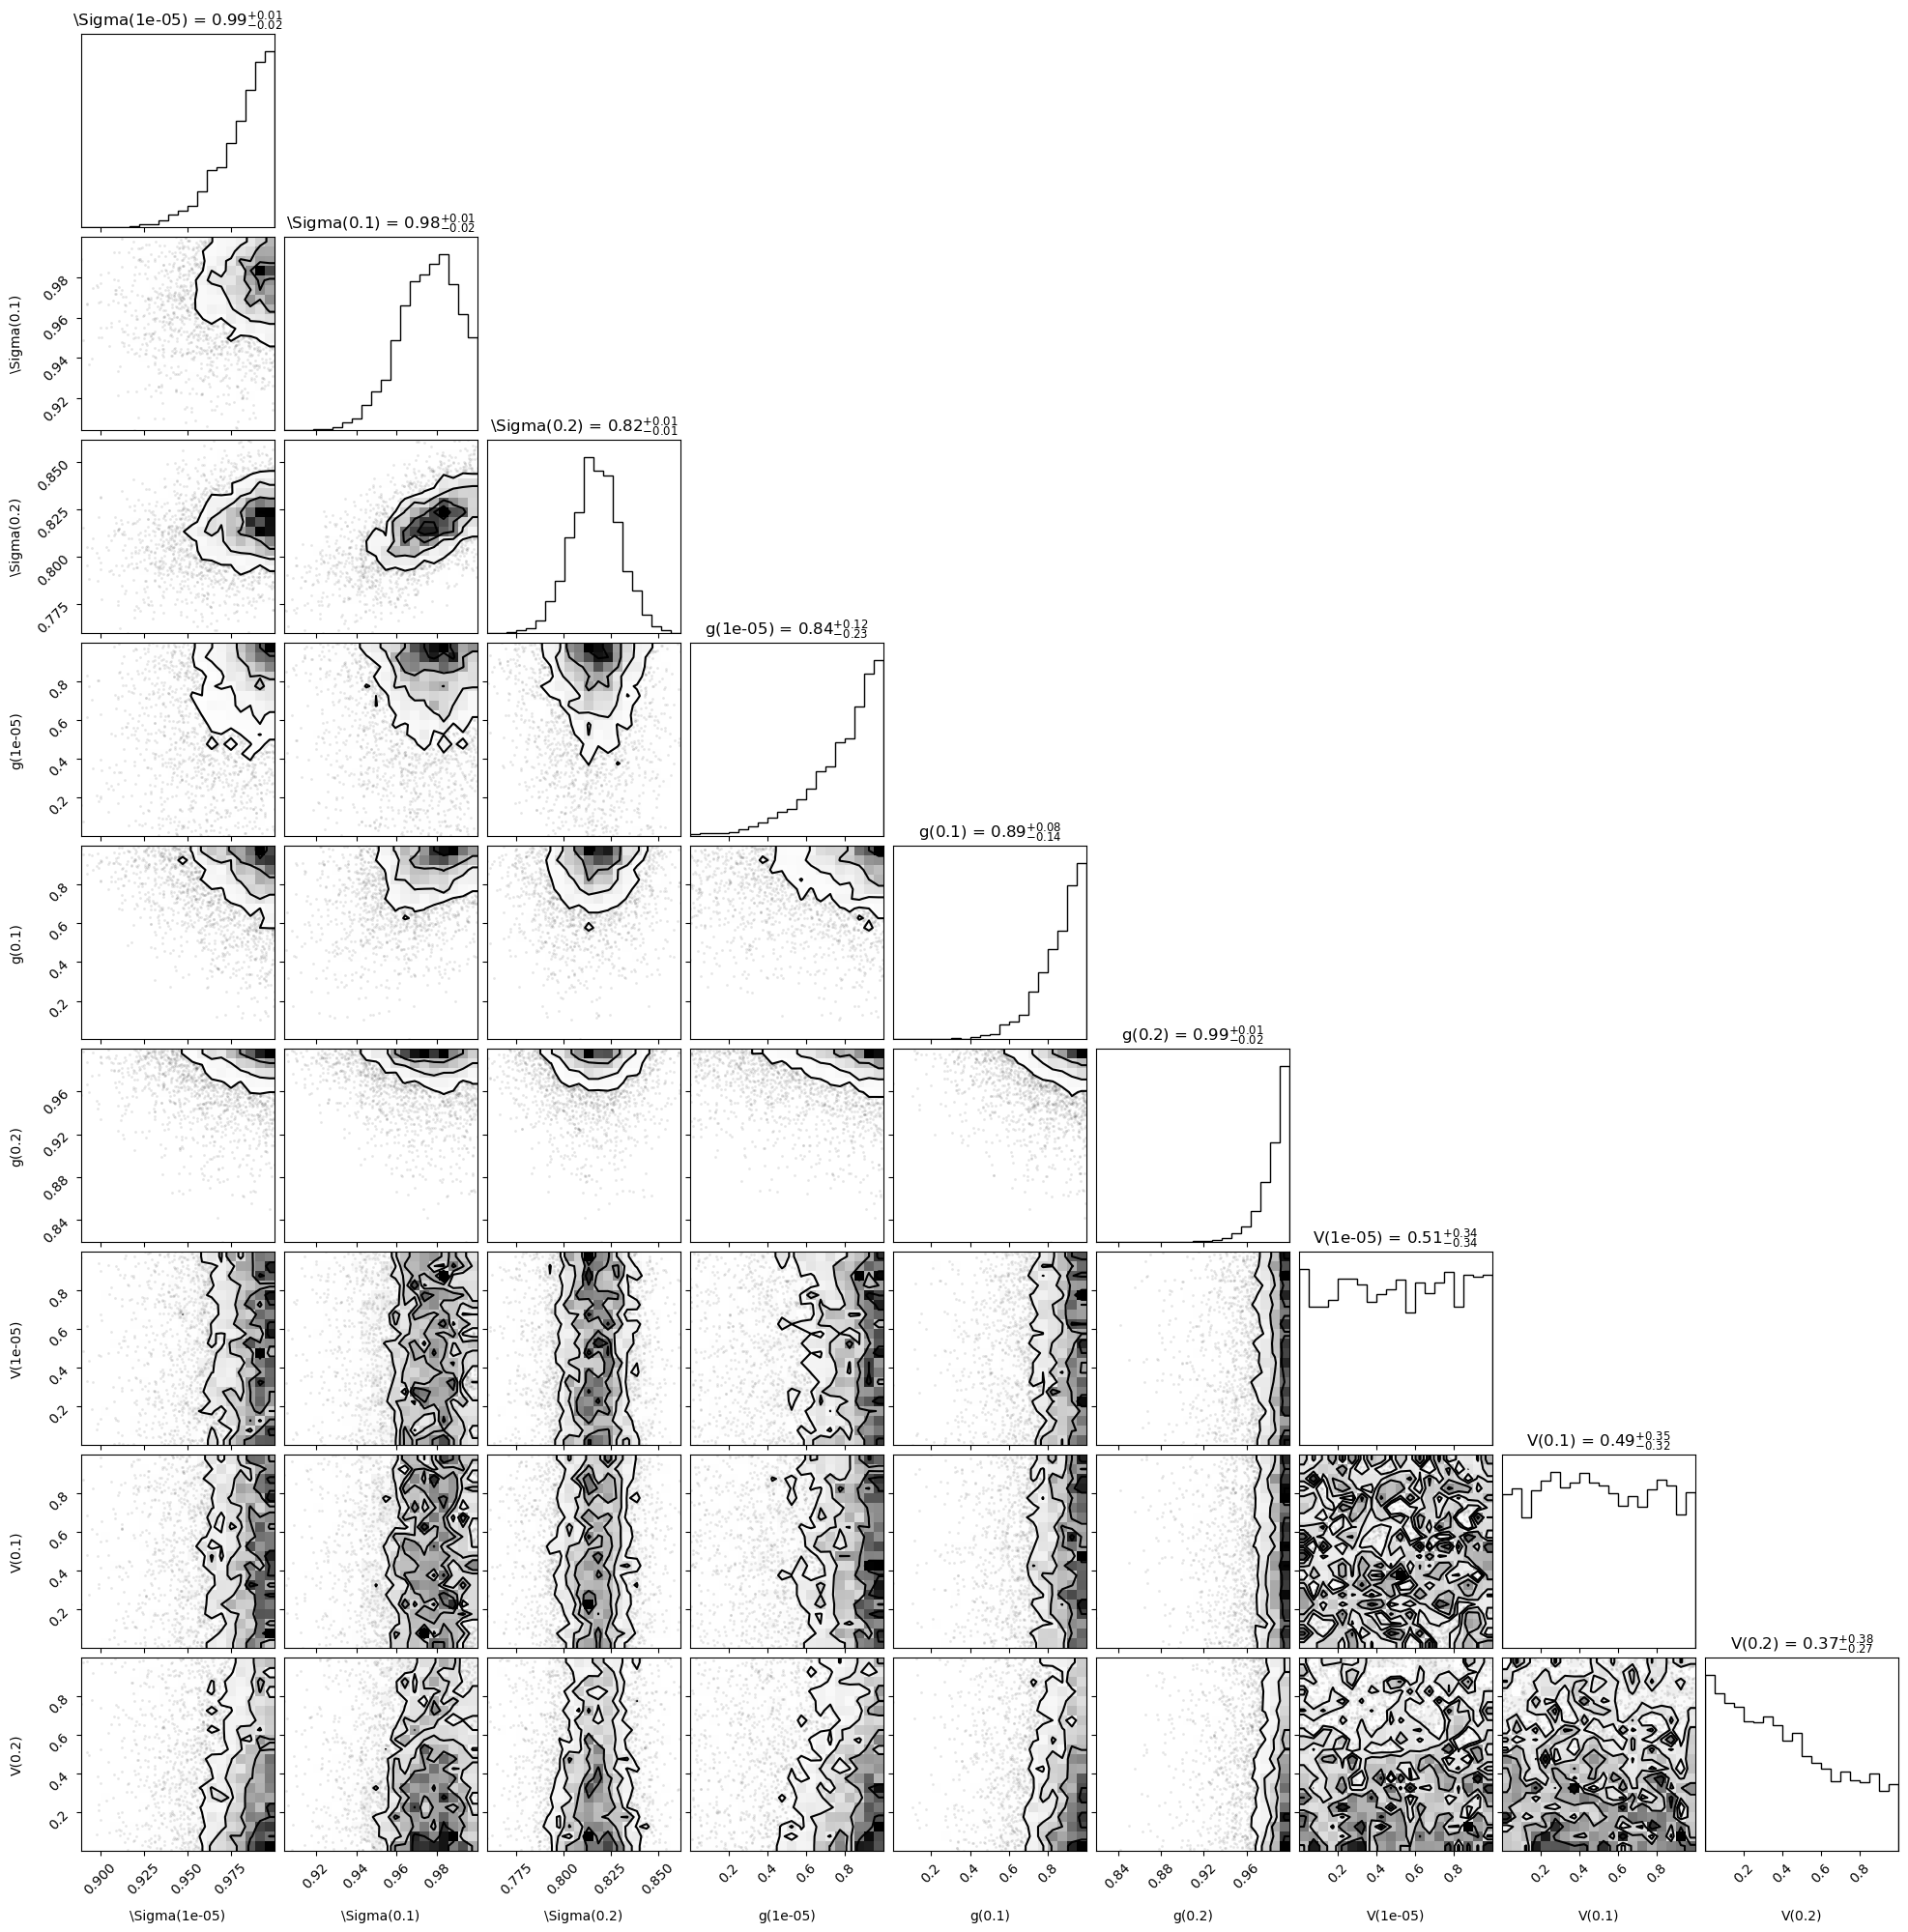

In [22]:
from ultranest.plot import cornerplot

cornerplot(ultranest_result)

In [45]:
sample = jnp.linspace(1,3,9)
interp_grid = interpolate_grid(sample)
print(interp_grid.shape)

interp_grid[25]

(50, 14)


Array([0.       , 1.0162171, 1.7662171, 2.5162172, 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       ], dtype=float32)

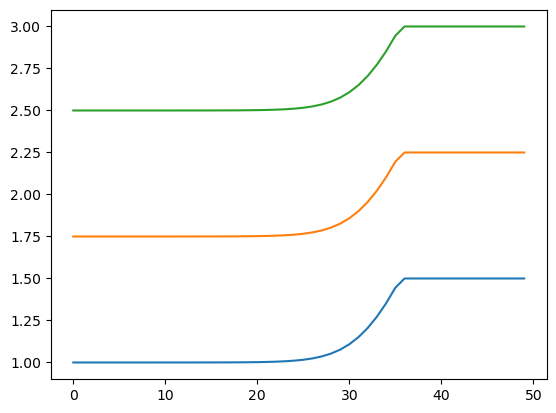

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(interp_grid[:,1])
ax.plot(interp_grid[:,2])
ax.plot(interp_grid[:,3])
